In [41]:
import pandas as pd

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

import env
import acquire
import prepare

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
import graphviz
from graphviz import Graph

In [2]:
titanic = acquire.get_titanic_data()
titanic_df = titanic.copy()
titanic_df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [3]:
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town', 'embarked']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [4]:
titanic_df = prep_titanic(titanic_df)
titanic_df.head()

,survived,pclass,age,sibsp,parch,fare,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,1,0,0
2,1,3,26.0,0,0,7.9250,1,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,0,1


In [5]:
def train_validate_test_split(df, target):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes)
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .25*.90= 22.5% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2,  
                                            stratify=df[target])
    
    
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       stratify=train_validate[target])
    return train, validate, test

In [6]:
train, validate, test = train_validate_test_split(titanic_df, target = 'survived')

In [52]:
train.shape, validate.shape, test.shape

((398, 11), (171, 11), (143, 11))

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 500 to 100
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            398 non-null    int64  
 1   pclass              398 non-null    int64  
 2   age                 398 non-null    float64
 3   sibsp               398 non-null    int64  
 4   parch               398 non-null    int64  
 5   fare                398 non-null    float64
 6   alone               398 non-null    int64  
 7   is_female           398 non-null    uint8  
 8   embark_Cherbourg    398 non-null    uint8  
 9   embark_Queenstown   398 non-null    uint8  
 10  embark_Southampton  398 non-null    uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 26.4 KB


In [7]:
train['baseline1'] = 0

validate['baseline1'] = 0

test['baseline1'] = 0

In [55]:
train.survived.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [61]:
baseline_accuracy = (train.survived == train.baseline1).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (validate.survived == validate.baseline1).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (test.survived == test.baseline1).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 59.55%
baseline accuracy: 59.65%
baseline accuracy: 59.44%


In [8]:
X_train = train.drop(columns=['survived', 'baseline1'])
y_train = train.survived

X_validate = validate.drop(columns=['survived', 'baseline1'])
y_validate = validate.survived

X_test = test.drop(columns=['survived', 'baseline1'])
y_test = test.survived

In [9]:
clf = DecisionTreeClassifier(max_depth=3)

In [27]:
clf2 = DecisionTreeClassifier(max_depth=8)

In [10]:
clf = clf.fit(X_train, y_train)

In [28]:
clf2 = clf2.fit(X_train, y_train)

In [11]:
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [29]:
dot_data = export_graphviz(clf2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [30]:
y_pred2 = clf2.predict(X_train)
y_pred2[0:4]

array([0, 0, 0, 0])

In [18]:
y_pred = clf.predict(X_train)
y_pred[0:4]

array([1, 0, 0, 1])

In [19]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:4]

array([[0.4       , 0.6       ],
       [0.90909091, 0.09090909],
       [0.90909091, 0.09090909],
       [0.42553191, 0.57446809]])

In [31]:
y_pred_proba2 = clf2.predict_proba(X_train)
y_pred_proba2[0:4]

array([[0.72727273, 0.27272727],
       [0.5       , 0.5       ],
       [0.9       , 0.1       ],
       [0.53333333, 0.46666667]])

In [20]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.84


In [32]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.93


In [21]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[193,  44],
       [ 21, 140]])

In [53]:
print("First Descision Tree Model")
print("-------------------------------")
#TP/TP+FN
print("True Positive Rate: ", round((193/ (193+21)), 2))

#FP / FP+TN
print("False Positive Rate: ", round((44 / (44 + 140)), 2))

#TN / TN+FP
print("True Negative Rate: ", round((140 / (140+44)), 2))

#FN / FN + TP
print("False Negative Rate: ", round((21 / (21+193)), 2))

First Descision Tree Model
-------------------------------
True Positive Rate:  0.9
False Positive Rate:  0.24
True Negative Rate:  0.76
False Negative Rate:  0.1


In [33]:
# confusion matrix

confusion_matrix(y_train, y_pred2)

array([[236,   1],
       [ 25, 136]])

In [54]:
print("Second Descision Tree Model")
print("-------------------------------")
#TP/TP+FN
print("True Positive Rate: ", round((236/ (236+25)), 2))

#FP / FP+TN
print("False Positive Rate: ", round((1 / (1 + 136)), 2))

#TN / TN+FP
print("True Negative Rate: ", round((136/ (136+1)), 2))

#FN / FN + TP
print("False Negative Rate: ", round((25/ (25+236)), 2))

Second Descision Tree Model
-------------------------------
True Positive Rate:  0.9
False Positive Rate:  0.01
True Negative Rate:  0.99
False Negative Rate:  0.1


In [22]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [23]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,193,44
1,21,140


In [34]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(y_train, y_pred2), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,236,1
1,25,136


In [24]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.86       237
           1       0.76      0.87      0.81       161

    accuracy                           0.84       398
   macro avg       0.83      0.84      0.83       398
weighted avg       0.84      0.84      0.84       398



In [35]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       237
           1       0.99      0.84      0.91       161

    accuracy                           0.93       398
   macro avg       0.95      0.92      0.93       398
weighted avg       0.94      0.93      0.93       398



# Evaluate Validate

In [25]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.77


In [36]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf2.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.83


In [26]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.78      0.80       102
           1       0.70      0.74      0.72        69

    accuracy                           0.77       171
   macro avg       0.76      0.76      0.76       171
weighted avg       0.77      0.77      0.77       171



In [38]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred2 = clf2.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred2))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86       102
           1       0.83      0.72      0.78        69

    accuracy                           0.83       171
   macro avg       0.83      0.81      0.82       171
weighted avg       0.83      0.83      0.83       171



# Exercises: random forest
Continue working in your model file with titanic data to do the following:

Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

Evaluate your results using the model score, confusion matrix, and classification report.

Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

Run through steps increasing your min_samples_leaf and decreasing your max_depth.

What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [56]:
clf3 = RandomForestClassifier(max_depth=10, min_samples_leaf=1)

In [58]:
clf3 = clf3.fit(X_train, y_train)

In [60]:
print(clf3.feature_importances_)

[0.12189297 0.23254398 0.04112155 0.04400997 0.24650336 0.01920298
 0.25749233 0.01890116 0.00380245 0.01452924]


In [61]:
y_pred = clf3.predict(X_train)
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

In [62]:
y_pred_proba = clf3.predict_proba(X_train)
y_pred_proba

array([[0.19669048, 0.80330952],
       [0.33332291, 0.66667709],
       [0.90635688, 0.09364312],
       [0.61694606, 0.38305394],
       [0.4179016 , 0.5820984 ],
       [0.97343187, 0.02656813],
       [0.03      , 0.97      ],
       [0.06      , 0.94      ],
       [0.1637336 , 0.8362664 ],
       [0.97343187, 0.02656813],
       [0.7810303 , 0.2189697 ],
       [0.768     , 0.232     ],
       [0.05632909, 0.94367091],
       [0.97883117, 0.02116883],
       [0.18916667, 0.81083333],
       [0.03222222, 0.96777778],
       [0.075     , 0.925     ],
       [0.        , 1.        ],
       [0.95105626, 0.04894374],
       [0.69160408, 0.30839592],
       [0.046     , 0.954     ],
       [0.12006952, 0.87993048],
       [0.25791721, 0.74208279],
       [0.84955519, 0.15044481],
       [0.28771795, 0.71228205],
       [0.9449026 , 0.0550974 ],
       [0.95476052, 0.04523948],
       [0.90876997, 0.09123003],
       [0.22007737, 0.77992263],
       [0.01567974, 0.98432026],
       [0.

In [63]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(clf3.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.97


In [64]:
print(confusion_matrix(y_train, y_pred))

[[236   1]
 [ 10 151]]


In [68]:
TP = 236
FP = 1
FN = 10
TN = 151

print("Random Forest Model")
print("-------------------------------")
#TP/TP+FN
print("True Positive Rate: ", round((TP/ (TP+FN)), 2))

#FP / FP+TN
print("False Positive Rate: ", round((FP / (FP + TN)), 2))

#TN / TN+FP
print("True Negative Rate: ", round((TN/ (TN+FP)), 2))

#FN / FN + TP
print("False Negative Rate: ", round((FN/ (FN+TP)), 2))

Random Forest Model
-------------------------------
True Positive Rate:  0.96
False Positive Rate:  0.01
True Negative Rate:  0.99
False Negative Rate:  0.04


In [65]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       237
           1       0.99      0.94      0.96       161

    accuracy                           0.97       398
   macro avg       0.98      0.97      0.97       398
weighted avg       0.97      0.97      0.97       398



### Chaning max_depth and min_samples_leaf parameters

In [70]:
clf4 = RandomForestClassifier(max_depth=5, min_samples_leaf=3)
clf4 = clf4.fit(X_train, y_train)

y_pred2 = clf4.predict(X_train)
#y_pred
y_pred_proba2 = clf4.predict_proba(X_train)
#y_pred_proba2

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(clf4.score(X_train, y_train)))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred2))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred2))

Accuracy of random forest classifier on training set: 0.88
---------------------------------------------------------
---------------------------------------------------------

[[225  12]
 [ 37 124]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       237
           1       0.91      0.77      0.84       161

    accuracy                           0.88       398
   macro avg       0.89      0.86      0.87       398
weighted avg       0.88      0.88      0.87       398



In [71]:
TP = 225
FP = 12
FN = 37
TN = 124

print("Random Forest Model")
print("-------------------------------")
#TP/TP+FN
print("True Positive Rate: ", round((TP/ (TP+FN)), 2))

#FP / FP+TN
print("False Positive Rate: ", round((FP / (FP + TN)), 2))

#TN / TN+FP
print("True Negative Rate: ", round((TN/ (TN+FP)), 2))

#FN / FN + TP
print("False Negative Rate: ", round((FN/ (FN+TP)), 2))

Random Forest Model
-------------------------------
True Positive Rate:  0.86
False Positive Rate:  0.09
True Negative Rate:  0.91
False Negative Rate:  0.14


In [ ]:


clf4 = RandomForestClassifier(max_depth=5, min_samples_leaf=3)
clf4 = clf4.fit(X_train, y_train)

y_pred2 = clf4.predict(X_train)
#y_pred
y_pred_proba2 = clf4.predict_proba(X_train)
#y_pred_proba2

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(clf4.score(X_train, y_train)))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred2))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred2))

In [74]:
for i in range(10, 0, -1):
    print(i)

10
9
8
7
6
5
4
3
2
1


In [75]:
for i in range(3,10):
    for n in range(7, 1, -1):
        clf4 = RandomForestClassifier(max_depth=n, min_samples_leaf=i)
        clf4 = clf4.fit(X_train, y_train)

        y_pred2 = clf4.predict(X_train)
        #y_pred
        y_pred_proba2 = clf4.predict_proba(X_train)
        #y_pred_proba2

        print('Accuracy of random forest classifier on training set: {:.2f}'
         .format(clf4.score(X_train, y_train)))

        print("---------------------------------------------------------")
        print("---------------------------------------------------------\n")
        print(confusion_matrix(y_train, y_pred2))

        print("---------------------------------------------------------")
        print("---------------------------------------------------------\n")
        print(classification_report(y_train, y_pred2))
        

Accuracy of random forest classifier on training set: 0.90
---------------------------------------------------------
---------------------------------------------------------

[[222  15]
 [ 26 135]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       237
           1       0.90      0.84      0.87       161

    accuracy                           0.90       398
   macro avg       0.90      0.89      0.89       398
weighted avg       0.90      0.90      0.90       398

Accuracy of random forest classifier on training set: 0.90
---------------------------------------------------------
---------------------------------------------------------

[[224  13]
 [ 27 134]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-sco

Accuracy of random forest classifier on training set: 0.88
---------------------------------------------------------
---------------------------------------------------------

[[218  19]
 [ 30 131]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       237
           1       0.87      0.81      0.84       161

    accuracy                           0.88       398
   macro avg       0.88      0.87      0.87       398
weighted avg       0.88      0.88      0.88       398

Accuracy of random forest classifier on training set: 0.87
---------------------------------------------------------
---------------------------------------------------------

[[221  16]
 [ 34 127]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-sco

Accuracy of random forest classifier on training set: 0.86
---------------------------------------------------------
---------------------------------------------------------

[[220  17]
 [ 39 122]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       237
           1       0.88      0.76      0.81       161

    accuracy                           0.86       398
   macro avg       0.86      0.84      0.85       398
weighted avg       0.86      0.86      0.86       398

Accuracy of random forest classifier on training set: 0.85
---------------------------------------------------------
---------------------------------------------------------

[[220  17]
 [ 43 118]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-sco

Accuracy of random forest classifier on training set: 0.83
---------------------------------------------------------
---------------------------------------------------------

[[216  21]
 [ 45 116]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       237
           1       0.85      0.72      0.78       161

    accuracy                           0.83       398
   macro avg       0.84      0.82      0.82       398
weighted avg       0.84      0.83      0.83       398

Accuracy of random forest classifier on training set: 0.82
---------------------------------------------------------
---------------------------------------------------------

[[220  17]
 [ 53 108]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-sco

In [109]:
pd.set_option('display.max_rows', 10)

In [126]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
number_depths = 20

for i in range(1,number_depths):
    
    
    depth = number_depths - i
    
    clf4 = RandomForestClassifier(max_depth = depth, min_samples_leaf = i)
    clf4 = clf4.fit(X_train, y_train)

    y_pred2 = clf4.predict(X_train)
    #y_pred
    y_pred_proba2 = clf4.predict_proba(X_train)
    #y_pred_proba2

    in_sample_accuracy = clf4.score(X_train, y_train)
        
    out_of_sample_accuracy = clf4.score(X_validate, y_validate)

    output = {
        "max_depth": depth,
        "min_sample_leaf": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
        
    metrics.append(output)
    
        
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
#df.sort_values(by = ['max_depth', 'min_sample_leaf'], ascending = [False, True])
df

,max_depth,min_sample_leaf,train_accuracy,validate_accuracy,difference
0,19,1,0.989950,0.807018,0.182932
1,18,2,0.922111,0.818713,0.103397
2,17,3,0.904523,0.830409,0.074113
3,16,4,0.891960,0.818713,0.073246
4,15,5,0.874372,0.818713,0.055658
...,...,...,...,...,...
14,5,15,0.829146,0.777778,0.051368
15,4,16,0.826633,0.771930,0.054703
16,3,17,0.814070,0.771930,0.042141
17,2,18,0.786432,0.795322,-0.008889


In [110]:
df.sort_values(by = ['max_depth', 'min_sample_leaf'], ascending = [False, True])

,max_depth,min_sample_leaf,train_accuracy,validate_accuracy,difference
0,14,3,0.899497,0.836257,0.063240
1,14,4,0.899497,0.818713,0.080784
2,14,5,0.884422,0.818713,0.065709
3,14,6,0.881910,0.818713,0.063196
4,14,7,0.874372,0.824561,0.049810
...,...,...,...,...,...
12,14,15,0.834171,0.771930,0.062241
13,14,16,0.839196,0.771930,0.067266
14,14,17,0.811558,0.771930,0.039628
15,14,18,0.821608,0.777778,0.043830


In [127]:
df1 = df.sort_values(by = ['max_depth', 'min_sample_leaf'], ascending = [True, False])

In [105]:
df1.head(10)

,max_depth,min_sample_leaf,train_accuracy,validate_accuracy,difference
0,3,10,0.899497,0.836257,0.063240
1,3,9,0.899497,0.824561,0.074936
2,3,8,0.894472,0.830409,0.064063
3,3,7,0.889447,0.824561,0.064886
4,3,6,0.891960,0.836257,0.055702
5,3,5,0.879397,0.818713,0.060684
6,3,4,0.861809,0.783626,0.078183
7,3,3,0.834171,0.801170,0.033001
8,3,2,0.811558,0.783626,0.027932
9,4,10,0.894472,0.824561,0.069911


<AxesSubplot:xlabel='max_depth'>

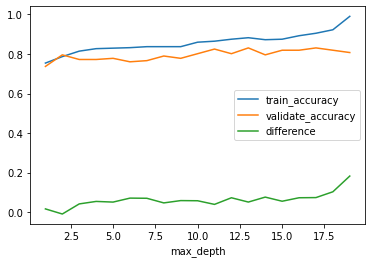

In [128]:
df1.set_index('max_depth')[['train_accuracy', 'validate_accuracy', 'difference']].plot()

In [129]:
df[df.difference <= 0.05].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,min_sample_leaf,train_accuracy,validate_accuracy,difference
8,11,9,0.864322,0.824561,0.039760
17,2,18,0.786432,0.795322,-0.008889
11,8,12,0.836683,0.789474,0.047210
16,3,17,0.814070,0.771930,0.042141
18,1,19,0.753769,0.736842,0.016927


# KNN Exercises

1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

2. Evaluate your results using the model score, confusion matrix, and classification report.

3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

4. Run through steps 2-4 setting k to 10

5. Run through setps 2-4 setting k to 20

6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

7. Which model performs best on our out-of-sample data from validate?

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [3]:
titanic = acquire.get_titanic_data()
titanic_df = titanic.copy()
titanic_df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [4]:
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town', 'embarked']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [7]:
titanic_df = prep_titanic(titanic_df)

In [5]:
def train_validate_test_split(df, target):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes)
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .25*.90= 22.5% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2,  
                                            stratify=df[target])
    
    
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       stratify=train_validate[target])
    return train, validate, test

In [8]:
train, validate, test = train_validate_test_split(titanic_df, target = 'survived')

In [9]:
train.shape

(398, 11)

In [10]:
train['baseline1'] = 0

validate['baseline1'] = 0

test['baseline1'] = 0

In [11]:
X_train = train.drop(columns=['survived', 'baseline1'])
y_train = train.survived

X_validate = validate.drop(columns=['survived', 'baseline1'])
y_validate = validate.survived

X_test = test.drop(columns=['survived', 'baseline1'])
y_test = test.survived

In [13]:
knn = KNeighborsClassifier()

In [14]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
y_pred = knn.predict(X_train)

In [16]:
accuracy = knn.score(X_train, y_train)

print("This is the accuracy: ", round(accuracy, 3))

This is the accuracy:  0.759


In [18]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       237
           1       0.70      0.70      0.70       161

    accuracy                           0.76       398
   macro avg       0.75      0.75      0.75       398
weighted avg       0.76      0.76      0.76       398



In [19]:
print(confusion_matrix(y_train, y_pred))

[[189  48]
 [ 48 113]]


In [20]:
print(knn.score(X_train, y_train))

0.7587939698492462


In [24]:
TP= 189
TN = 113
FP = 48
FN = 48

ALL = TP + TN + FP + FN



print("KNN Model")
print("-------------------------------")
#TP/TP+FN
print("True Positive Rate: ", round((TP/ (TP+FN)), 2))

#FP / FP+TN
print("False Positive Rate: ", round((FP / (FP + TN)), 2))

#TN / TN+FP
print("True Negative Rate: ", round((TN/ (TN+FP)), 2))

#FN / FN + TP
print("False Negative Rate: ", round((FN/ (FN+TP)), 2))

accuracy = (TP + TN)/ALL
precision = TP/(TP+FP) 
recall = TP/(TP+FN)
print("-------------------------------")
print("-------------------------------")

print("Accuracy : ", round((accuracy), 2))
print("Precision : ", round((precision), 2))
print("Recall : ", round((recall), 2))

f1_score = 2*(precision*recall)/(precision+recall) 
support_pos = TP + FN 
support_neg = FP + TN 
print("-------------------------------")
print("-------------------------------")

print("F1_Score : ", round((f1_score), 2))
print("Support Positive : ", support_pos)
print("Support Negative : ", support_neg)

KNN Model
-------------------------------
True Positive Rate:  0.8
False Positive Rate:  0.3
True Negative Rate:  0.7
False Negative Rate:  0.2
-------------------------------
-------------------------------
Accuracy :  0.76
Precision :  0.8
Recall :  0.8
-------------------------------
-------------------------------
F1_Score :  0.8
Support Positive :  237
Support Negative :  161


In [29]:
knn2 = KNeighborsClassifier(10)
knn2.fit(X_train, y_train)
y_pred = knn2.predict(X_train)

print(classification_report(y_train, y_pred))
print("------------------------------------")
print(knn2.score(X_train, y_train))


              precision    recall  f1-score   support

           0       0.75      0.84      0.79       237
           1       0.71      0.59      0.65       161

    accuracy                           0.74       398
   macro avg       0.73      0.71      0.72       398
weighted avg       0.74      0.74      0.73       398

------------------------------------
0.7386934673366834


In [30]:
knn3 = KNeighborsClassifier(20)
knn3.fit(X_train, y_train)
y_pred = knn3.predict(X_train)


print(classification_report(y_train, y_pred))
print("------------------------------------")
print(knn3.score(X_train, y_train))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       237
           1       0.72      0.57      0.63       161

    accuracy                           0.74       398
   macro avg       0.73      0.71      0.71       398
weighted avg       0.73      0.74      0.73       398

------------------------------------
0.7361809045226131


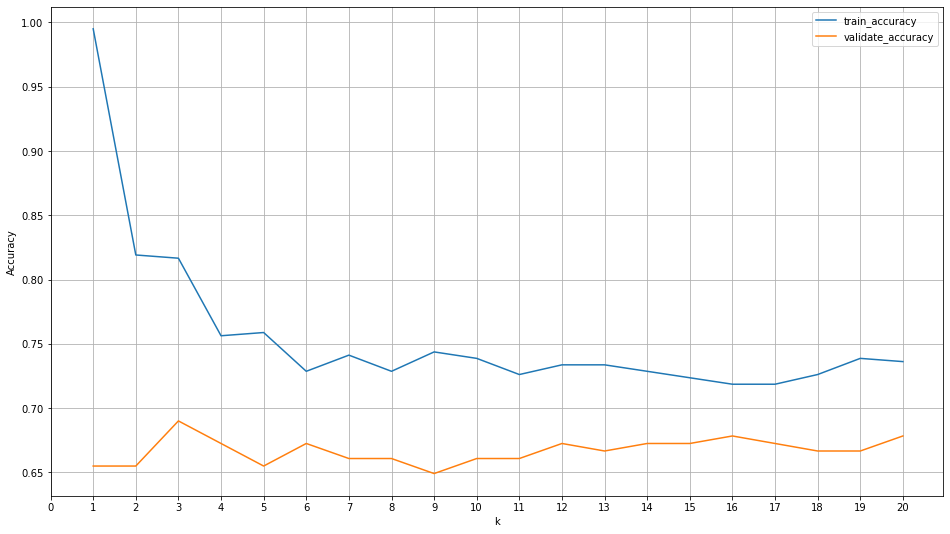

In [33]:
metrics = []

# loop through different values of k
for k in range(1, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)

# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

# Regression Exercises: 

In [51]:
titanic_df = acquire.get_titanic_data()
titanic_df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [52]:
# Handle missing ages
avg_age = titanic_df.age.mean()
titanic_df.age = titanic_df.age.fillna(avg_age)

# Encode the gender column
titanic_df["is_female"] = (titanic_df.sex == "female").astype('int')

# Encode the embarked_town
# Embark_Town values are Southampton, Cherbourg, and Queenstown
dummy_df = pd.get_dummies(titanic_df[['embark_town']], dummy_na=False, drop_first=True)
titanic_df = pd.concat([titanic_df, dummy_df], axis=1)

# Drop unnecessary columns
titanic_df = titanic_df.drop(columns=["passenger_id", "deck", "class", "embarked", "sex", "embark_town"])

titanic_df.head(3)

,survived,pclass,age,sibsp,parch,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,1,0,1


In [53]:
train, validate, test = prepare.split_data(titanic_df)

In [37]:
train.head()

,survived,pclass,age,sibsp,parch,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton
583,0,1,36.000000,0,0,40.1250,1,0,0,0
165,1,3,9.000000,0,2,20.5250,0,0,0,1
50,0,3,7.000000,4,1,39.6875,0,0,0,1
259,1,2,50.000000,0,1,26.0000,0,1,0,1
306,1,1,29.699118,0,0,110.8833,1,1,0,0


In [54]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [55]:
baseline_accuracy = (train.survived == 0).mean()

In [56]:
logit = LogisticRegression()

features = ["age", "pclass", "fare"]

logit.fit(X_train[features], y_train)

y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, pclass, and fare features")
print("Accuracy of Logistic Regression classifier on training set: ", 
      round(logit.score(X_train[features], y_train), 2))

Baseline is 0.62
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set:  0.7


In [43]:
logit1 = LogisticRegression()

features = ["age", "pclass", "fare", "is_female"]

logit1.fit(X_train[features], y_train)

y_pred = logit1.predict(X_train[features])

print("Logistic Regression using age, pclass, fare, and gender features")
print("Accuracy of Logistic Regression classifier on training set: ", 
      round(logit1.score(X_train[features], y_train), 2))

Logistic Regression using age, pclass, fare, and gender features
Accuracy of Logistic Regression classifier on training set:  0.81


In [47]:
logit2 = LogisticRegression()

logit2.fit(X_train, y_train)

y_pred = logit2.predict(X_train)

print("Model trained on all features")
print("Accuracy of Logistic Regression classifier on training set: ",
    (logit2.score(X_train, y_train)))

Model trained on all features
Accuracy of Logistic Regression classifier on training set:  0.8152610441767069


In [58]:
features = ["age", "pclass", "fare"]

y_pred = logit.predict(X_validate[features])

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       132
           1       0.70      0.43      0.53        82

    accuracy                           0.71       214
   macro avg       0.71      0.66      0.66       214
weighted avg       0.71      0.71      0.69       214



In [59]:
features = ["age", "pclass", "fare", "is_female"]

y_pred = logit1.predict(X_validate[features])

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       132
           1       0.72      0.67      0.70        82

    accuracy                           0.78       214
   macro avg       0.76      0.76      0.76       214
weighted avg       0.77      0.78      0.77       214



In [60]:
y_pred = logit2.predict(X_validate)

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.82       132
           1       0.74      0.65      0.69        82

    accuracy                           0.78       214
   macro avg       0.77      0.75      0.76       214
weighted avg       0.77      0.78      0.77       214



In [ ]:
# Logit 1 regression has the best results